# Get the data to illustrate the Modifiable Areal Unit Problem

This notebook downloads geography and data from the Office for National Statistics (ONS), processing it and saving it to a GeoPackage for further investigation of the dwelling density of Greater London at the time of the 2011 census.

## 0. Import required libraries

In [1]:
# File management and downloads
from pathlib import Path
from urllib.request import urlretrieve
import requests
import zipfile
# Mapping
import geopandas as gpd
# Data and plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
# Geometry operations
from shapely.ops import unary_union

## 1. Download geometry and data from the Office for National Statistics

The process uses 2011 census data from the Office for National Statistics. This notebook automates the process of downloading both the geography/geometry and the data. Please see the following pages for further information on each data source:

### Geometry

- [Built Up Areas](https://geoportal.statistics.gov.uk/datasets/built-up-areas-december-2011-boundaries-v2-1)
- [Census Merged Local Authority Districts](https://geoportal.statistics.gov.uk/datasets/census-merged-local-authority-districts-december-2011-generalised-clipped-boundaries-in-great-britain)
- [Lower Layer Super Output Areas](https://geoportal.statistics.gov.uk/datasets/lower-layer-super-output-areas-december-2011-boundaries-ew-bfc)
- [Middle Layer Super Output Areas](https://geoportal.statistics.gov.uk/datasets/middle-layer-super-output-areas-december-2011-boundaries-ew-bfc)
- [Output Areas](https://geoportal.statistics.gov.uk/datasets/output-areas-december-2011-boundaries-ew-bgc)

### Data

All of the data comes from the same page, just downloaded to match the different sub-divisions.

- [Dwellings, household spaces and accommodation type](https://www.nomisweb.co.uk/census/2011/ks401ew)

### Lookup

It also downloads a look-up table. The look-up table is necessary to link the geometries together across the scales as the UK's census sub-division codes are not hierarchical i.e. the code for a smaller sub-division is not based on the code for the larger sub-division that it forms part of.

- [Output Area to Lower Layer Super Output Area to Middle Layer Super Output Area to Local Authority District (December 2011) Lookup in England and Wales](https://geoportal.statistics.gov.uk/datasets/output-area-to-lower-layer-super-output-area-to-middle-layer-super-output-area-to-local-authority-district-december-2011-lookup-in-england-and-wales)

In [2]:
datasets = {'Countries':{'type':'geo',
                         'geo_filename':'Countries_geometry.geojson',
                         'geo_url':'https://opendata.arcgis.com/datasets/3d0a732e0b974a05b1766b93e2682d1f_0.geojson',
                          },
              'BUA':{'type':'geodata',
                     'geo_filename':'BUA_geometry.geojson',
                     'geo_url':'https://opendata.arcgis.com/datasets/210f705366044b8c9ca3fa6f4f83fa5d_0.geojson',
                     'data_filename':'KS401EW_BUA.csv',
                     'data_url':'https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=TYPE269',
                     'geo_code_column':'bua11cd',
                     'data_code_column':'geography code',
                    },
              'LAD':{'type':'geodata',
                     'geo_filename':'LAD_geometry.geojson',
                     'geo_url':'https://opendata.arcgis.com/datasets/8c398b60a71d44e2bdf8b5b3bb951988_0.geojson',
                     'data_filename':'KS401EW_LAD.csv',
                     'data_url':'https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=TYPE464',
                     'geo_code_column':'lad11cd',
                     'data_code_column':'geography code',
                     'lookup_code_column':'LAD11CD',
                    },
              'LSOA':{'type':'geodata',
                      'geo_filename':'LSOA_geometry.geojson',
                      'geo_url':'https://opendata.arcgis.com/datasets/e886f1cd40654e6b94d970ecf437b7b5_0.geojson',
                      'data_filename':'KS401EW_LSOA.csv',
                      'data_url':'https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=TYPE298',
                      'geo_code_column':'LSOA11CD',
                      'data_code_column':'geography code',
                      'lookup_code_column':'LSOA11CD',
                     },
              'MSOA':{'type':'geodata',
                      'geo_filename':'MSOA_geometry.geojson',
                      'geo_url':'https://opendata.arcgis.com/datasets/02aa733fc3414b0ea4179899e499918d_0.geojson',
                      'data_filename':'KS401EW_MSOA.csv',
                      'data_url':'https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=TYPE297',
                      'geo_code_column':'msoa11cd',
                      'data_code_column':'geography code',
                      'lookup_code_column':'MSOA11CD',
                     },
              'OA':{'type':'geodata',
                    'geo_filename':'OA_geometry.geojson',
                    'geo_url':'https://opendata.arcgis.com/datasets/f79fc19485704ce68523d8d70d84a913_0.geojson',
                    'data_filename':'KS401EW_OA.csv',
                    'data_url':'https://www.nomisweb.co.uk/api/v01/dataset/nm_618_1.bulk.csv?time=latest&measures=20100&rural_urban=total&geography=2013265927TYPE299',
                    'geo_code_column':'OA11CD',
                    'data_code_column':'geography code',
                    'lookup_code_column':'OA11CD',
                   },
              'LookUp':{'type':'geo',
                        'geo_filename':'LookUp.geojson',
                        'geo_url':'https://opendata.arcgis.com/datasets/6ecda95a83304543bc8feedbd1a58303_0.geojson',
                       },
             }

## 1.1 Download the datasets

***WARNING: This cell will download around 2.7GB of data - it should only be necessary to run this cell once.***

In [ ]:
# iterate through the dictionary downloading the relevant files
for dataset in datasets:
    # Use urlretrieve to download the geojsons
    if (datasets[dataset]['type'] == 'geodata') or (datasets[dataset]['type'] == 'geo'):
        geo_file_path = Path("Data_In") / datasets[dataset]['geo_filename']
        if not geo_file_path.is_file():
            # Download the file from this location
            # and save it (takes a minute or two)
            print("retrieving:", datasets[dataset]['geo_filename'])
            urlretrieve(datasets[dataset]['geo_url'], geo_file_path)
            print("saved:", datasets[dataset]['geo_filename'])
    # Use requests to download the csvs
    if (datasets[dataset]['type'] == 'geodata'):
        # Define the filename for the BUA data
        data_file_path = Path("Data_In") / datasets[dataset]['data_filename']
        # If we don't already have the file
        if not data_file_path.is_file():
            # use requests to get the data from this address
            print("retrieving:", datasets[dataset]['data_filename'])
            # keep the response
            response = requests.get(datasets[dataset]['data_url'])
            # write it into the defined filename
            with open(data_file_path, 'wb') as out:
                out.write(response.content)
            print("saved:", datasets[dataset]['data_filename'])
print("Complete")

## 1.2 Read the lookup table & filter it to London

The downloaded geometry, data and lookup table cover all of England and Wales. The lookup table contains all of the census sub-division codes at the various scales of geography. By filtering it to only cover the Local Authorities in Greater London we can then use the reduced table to filter all of the other files to only those codes relevant to Greater London.

In [3]:
lookup = gpd.read_file(Path("Data_In") / 'LookUp.geojson')

print("lookup shape:", lookup.shape)
print("number of LADs:", len(lookup['LAD11CD'].unique()))

# Filter the look up table to the codes for London LADs
London_lookup = lookup[(lookup['LAD11CD'] >= 'E09000001') &
                       (lookup['LAD11CD'] <= 'E09000033')]

print("London lookup shape:", London_lookup.shape)
print("number of London LADs:", len(London_lookup['LAD11CD'].unique()))

London_lookup

lookup shape: (181408, 10)
number of LADs: 348
London lookup shape: (25053, 10)
number of London LADs: 33


,OA11CD,LSOA11CD,LSOA11NM,MSOA11CD,MSOA11NM,LAD11CD,LAD11NM,LAD11NMW,ObjectId,geometry
0,E00000001,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,None,1,None
1,E00000003,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,None,2,None
2,E00000005,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,None,3,None
3,E00000007,E01000001,City of London 001A,E02000001,City of London 001,E09000001,City of London,None,4,None
4,E00000010,E01000003,City of London 001C,E02000001,City of London 001,E09000001,City of London,None,5,None
...,...,...,...,...,...,...,...,...,...,...
171171,E00176548,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,None,171172,None
171172,E00176549,E01033742,Greenwich 007F,E02000319,Greenwich 007,E09000011,Greenwich,None,171173,None
171173,E00176550,E01033743,Greenwich 002H,E02000314,Greenwich 002,E09000011,Greenwich,None,171174,None
171174,E00176551,E01001640,Greenwich 035A,E02006928,Greenwich 035,E09000011,Greenwich,None,171175,None


## 1.3 Filter the datasets to London, calculate density, save to GeoPackage

This works through every scale in turn, joining the data to the geography and calculating the relevant dwelling density. It then writes the processed data out to separate layers in a single GeoPackage. Depending on your machine this cell will take a few minutes to run.

- Read each dataset
- Filter to London using the lookup table
- Project to the British National Grid
- Join the data and geography
- Calculate the dwelling density
- Write as a layer in a GeoPackage

In [4]:
# Path to save the data to
file_out = Path("Data_Gen") / "package.gpkg"

for dataset_key, dataset_value in datasets.items():
    if dataset_value['type'] == 'geodata':
        lookup_code_column = dataset_value.get('lookup_code_column') # Note this will be None for BUAs
        
        # Process the data
        ##################
        data_file_path = Path("Data_In") / dataset_value.get('data_filename')
        data_code_column = dataset_value.get('data_code_column')
        
        print("data_file_path:", data_file_path,
              "\ndata_code_column:", data_code_column,
              "\nlookup_code_column:",lookup_code_column)
        
        # read the csv
        data = pd.read_csv(data_file_path)
        
        # for entries with a lookup_code_column
        if lookup_code_column is not None:
            # filter it using the london look up table
            data = data[data[data_code_column].isin(London_lookup[lookup_code_column])]

        data.rename(columns={'Dwelling Type: All categories: Dwelling type; measures: Value':'Dwellings'},inplace=True)


        # Process the geometry
        ######################
        # Read the GeoJSON into a GeoPandas GeoDataFrame
        geo_file_path = Path("Data_In") / dataset_value.get('geo_filename')
        geo_code_column = dataset_value.get('geo_code_column')

        print("geo_file_path:", geo_file_path,
              "\ngeo_code_column:", geo_code_column,
              "\nlookup_code_column:",lookup_code_column)

        # read the geojson
        geo = gpd.read_file(geo_file_path)
        
        # for entries with a lookup_code_column
        if lookup_code_column is not None:
            # filter it using the london look up table
            geo = geo[geo[geo_code_column].isin(London_lookup[lookup_code_column])]

        # Project to the British National Grid
        print("\nProjecting to British National Grid")
        geo.to_crs("EPSG:27700", inplace=True)
        print("New CRS:", geo.crs)

        # Join the geometry and data
        ############################
        print("\nMerging geometry and data")
        geodata = geo.merge(data, left_on=geo_code_column, right_on=data_code_column)

        # Calculate Density
        ###################
        print("\nCalculating density")
        # Measure the area in hectares and write into a new column
        geodata['Area_ha'] = (geodata.area/10_000).round(2)
        geodata['Density_dha'] = (geodata['Dwellings'] / (geodata.area/10_000)).round(1)
        
        
        print("Total Dwellings:", geodata['Dwellings'].sum(),
              "\n Total Area_ha:", geodata['Area_ha'].sum().round(), "Total.area", geodata.area.sum().round(),
              "\n Overall Density:", (geodata['Dwellings'].sum()/((geodata.area/10_000).sum())).round())
        
        # Reduce to minimum columns
        ###########################
        geodata = geodata[['geography', 'geography code', 'Dwellings', 'Area_ha', 'Density_dha', 'geometry']]
        
        
        # Save the geodata
        ##################
        print("\nSaving the layer to the geopackage")
        geodata.to_file(file_out, layer=dataset_key, driver="GPKG", overwrite='yes')
        print("file written to:", file_out, "layer:", dataset_key)
        print("=====\n")

print("Complete")

data_file_path: Data_In/KS401EW_BUA.csv 
data_code_column: geography code 
lookup_code_column: None
geo_file_path: Data_In/BUA_geometry.geojson 
geo_code_column: bua11cd 
lookup_code_column: None

Projecting to British National Grid
New CRS: EPSG:27700

Merging geometry and data

Calculating density
Total Dwellings: 23161705 
 Total Area_ha: 1443538.0 Total.area 14435413558.0 
 Overall Density: 16.0

Saving the layer to the geopackage
file written to: Data_Gen/package.gpkg layer: BUA
=====

data_file_path: Data_In/KS401EW_LAD.csv 
data_code_column: geography code 
lookup_code_column: LAD11CD
geo_file_path: Data_In/LAD_geometry.geojson 
geo_code_column: lad11cd 
lookup_code_column: LAD11CD

Projecting to British National Grid
New CRS: EPSG:27700

Merging geometry and data

Calculating density
Total Dwellings: 3358163 
 Total Area_ha: 157351.0 Total.area 1573508035.0 
 Overall Density: 21.0

Saving the layer to the geopackage
file written to: Data_Gen/package.gpkg layer: LAD
=====

data_

## 2. Get building footprints for Greater London's combined political boundary and Built Up Area
### 2.1 Read in Built Up Area geometries and extract only Greater London

,geography,geography code,Dwellings,Area_ha,Density_dha,geometry
4704,Greater London BUA,E34004707,4035768,173789.68,23.2,"MULTIPOLYGON (((494951.269 160099.919, 494951...."


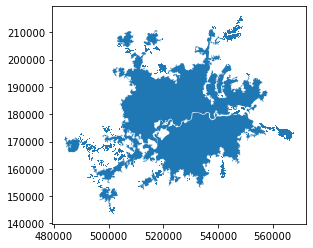

In [5]:
# Read the Built Up Areas from the geopackage
BUA = gpd.read_file('Data_Gen/package.gpkg', layer='BUA')
# Extract only Greater London
GLBUA = BUA[BUA['geography'].str.startswith('Greater London')]
GLBUA.plot()
GLBUA

### 2.2 Read in Local Authorities & dissolve to create Greater London's political boundary & dwelling density

,geometry,Dwellings,Area_ha,Density_dha
0,"MULTIPOLYGON (((547226.215 181299.305, 547320....",3358163,157350.81,21.3


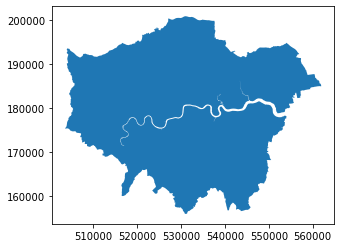

In [6]:
# Read the Local Authorities from the geopackage
LAD = gpd.read_file('Data_Gen/package.gpkg', layer='LAD')
# Create a temp column filled with 1s - this is a workaround to dissolve all rows together
LAD['temp']=1
# Dissolve the LADs together based on the new code, summing the number of dwellings and the areas
GL = LAD[['Dwellings', 'Area_ha', 'geometry', 'temp']].dissolve(by='temp', aggfunc='sum')
# Calculate a Greater London dwelling density
GL['Density_dha'] = (GL['Dwellings'] / GL['Area_ha']).round(1)
# reset the index
GL.reset_index(drop=True, inplace=True)
# show the new dataframe
GL.plot()
GL

## 2.3 Get the building footprints

To better visualise the uneven distribution of buildings across the capital and how this interacts with the geographic subdivisions to create the variation in measured dwelling densities we make use of building footprints from Open Data provided by the Ordnance Survey (OS OpenMap Local).

Alasdair Rae at the University of Sheffield has kindly processed the multiple tiles provided by the Ordnance Survey into more managable files.

- http://ajrae.staff.shef.ac.uk/buildings/ (Data is Ordnance Survey Open Data)

Here we work with his Midlands and South East file, manually downloading it and using a mask to reduce it to the combined geometry of Greater London's Built Up Area and political boundary.

***Warning: this is another large file that will take a while to process and display.***

In [7]:
# Create a single geometry that covers Greater London's Built Up Area and political boundary
GLBUAGL = unary_union([GLBUA.unary_union, GL.unary_union])
# Use this as a mask to only retrieve building footprints inside this area
Buildings = gpd.read_file('Data_In/Buildings_Midlands_SouthEast.gpkg',mask=GLBUAGL)
# Write out to a new, smaller file
Buildings.to_file('Data_Gen/Buildings_GLBUA.gpkg', driver="GPKG")

In [10]:
# Check the number of records and columns
Buildings.shape

(938070, 6)

,ID,FEATCODE,SQM,layer,path,geometry
0,88421681-E25E-4C01-B01C-14880800D503,15014,211.46140,south_east_england_buildings_clipped,/media/nick/1E70DF7C70DF58DB/GISData-GB/Alisda...,"MULTIPOLYGON Z (((484134.840 171432.070 0.000,..."
1,1E442E42-305F-4688-8C79-9F6D1DC5AF0A,15014,288.35105,south_east_england_buildings_clipped,/media/nick/1E70DF7C70DF58DB/GISData-GB/Alisda...,"MULTIPOLYGON Z (((484178.060 171469.790 0.000,..."
2,D6D53CD9-E6AD-4823-929C-8661F691BFC9,15014,302.07940,south_east_england_buildings_clipped,/media/nick/1E70DF7C70DF58DB/GISData-GB/Alisda...,"MULTIPOLYGON Z (((484117.100 171474.510 0.000,..."
3,7A3377AB-A114-4C69-9FCC-894B040DF62C,15014,330.73530,south_east_england_buildings_clipped,/media/nick/1E70DF7C70DF58DB/GISData-GB/Alisda...,"MULTIPOLYGON Z (((484211.700 171448.510 0.000,..."
4,C8E5B25C-EF5E-4609-8C3A-D2E4123581E8,15014,342.51990,south_east_england_buildings_clipped,/media/nick/1E70DF7C70DF58DB/GISData-GB/Alisda...,"MULTIPOLYGON Z (((484122.500 171490.620 0.000,..."


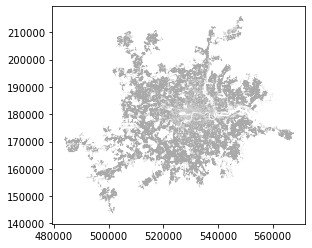

In [8]:
# Show result
Buildings.plot(color='darkgrey')
Buildings.head()

# 3. Greenbelt

Alongside a commitment to deliver London's housing need within its political boundary, successive mayors have also committed to doing this without building on the Greenbelt. As the name suggests, the Greenbelt is a belt around the edge of the city and so not evenly shared between Local Authorities. Here we download its geometry to be able to investigate its impact on measured dwelling densities.

The Ministry of Housing, Communities and Local Government makes the geometry available here:

https://data.gov.uk/dataset/d0337f1b-4ed9-4711-bb2f-7e4ddf569b0e/english-local-authority-green-belt-dataset

## 3.1 Download the Greenbelt geometry & unzip
***It should only be necessary to run this cell once.***

In [ ]:
greenbelt_filename = Path('Data_In')/'Greenbelt_Boundaries_2011_12.zip'
greenbelt_url = 'http://maps.communities.gov.uk/geoserver/dclg_inspire/ows?service=WFS&version=2.0.0&request=GetFeature&typeName=dclg_inspire:Local_Authority_Greenbelt_boundaries_2011-12&outputFormat=shape-zip&srsName=EPSG:4326'
# If we haven't already downloaded this file
if not greenbelt_filename.is_file():
    # use requests to get the data from this address
    print("retrieving:", greenbelt_filename)
    # keep the response
    response = requests.get(greenbelt_url)
    # write it into the defined filename
    with open(greenbelt_filename, 'wb') as out:
        out.write(response.content)
    print("saved:", greenbelt_filename)

# unzip the Greenbelt zip file
with zipfile.ZipFile(greenbelt_filename, 'r') as zipped_obj:
    zipped_obj.extractall(Path('Data_In'))

## 3.2 Read in the geometry & filter to only the London Area Greenbelt

In [11]:
greenbelt = gpd.read_file(Path('Data_In')/"Local_Authority_Greenbelt_boundaries_2011-12.shp")
greenbelt.to_crs("epsg:27700", inplace=True)
print(greenbelt['GB_name'].unique())
London_area_greenbelt = greenbelt[greenbelt['GB_name'] == 'London Area Greenbelt']
London_area_greenbelt.head()

['Liverpool, Manchester and West Yorks Greenbelt' 'London Area Greenbelt'
 'Gloucester Greenbelt' 'Morecombe Greenbelt' 'North East Greenbelt'
 'York Greenbelt' 'Oxford Greenbelt' 'Birmingham Greenbelt'
 'Stoke Greenbelt' 'Derby and Nottingham Greenbelt' 'Blackpool Greenbelt'
 'Bournemouth Greenbelt' 'Cambridge Greenbelt'
 'Burton upon Trent Greenbelt' 'Bristol and Bath Greenbelt']


,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry
1,London Area Greenbelt,Bracknell Forest (B),E06000036,3840.763418,55.789652,"POLYGON ((485134.226 175127.407, 485145.826 17..."
3,London Area Greenbelt,Greenwich London Boro,E09000011,0.539995,0.502667,"POLYGON ((544310.509 172281.442, 544294.034 17..."
4,London Area Greenbelt,Kingston upon Thames London Boro,E09000021,639.206900,19.333490,"POLYGON ((518183.753 165717.257, 518179.603 16..."
6,London Area Greenbelt,Maidstone District (B),E07000110,528.041171,12.548314,"POLYGON ((568276.850 153194.530, 568285.647 15..."
32,London Area Greenbelt,Mole Valley District,E07000170,19641.796455,183.180475,"POLYGON ((519306.083 159128.503, 519303.898 15..."


## 3.3 Reduce further to only those areas inside Greater London Local Authorities

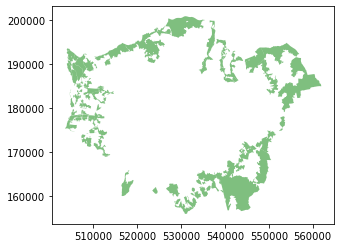

In [12]:
GL_greenbelt = London_area_greenbelt[London_area_greenbelt['ONS_Code'].isin(LAD['geography code'])].copy()
GL_greenbelt.plot(color='green', alpha=0.5)

In [13]:
# Check for invalid geometries
GL_greenbelt[~GL_greenbelt['geometry'].is_valid]

,GB_name,LA_Name,ONS_Code,Area_Ha,Perim_Km,geometry
3,London Area Greenbelt,Greenwich London Boro,E09000011,0.539995,0.502667,"POLYGON ((544310.509 172281.442, 544294.034 17..."
94,London Area Greenbelt,Bromley London Boro,E09000006,685.098137,34.015005,"POLYGON ((544717.059 172249.543, 544721.239 17..."
96,London Area Greenbelt,Bromley London Boro,E09000006,5431.453951,79.981709,"POLYGON ((542928.641 165940.420, 542922.450 16..."
252,London Area Greenbelt,Harrow London Boro,E09000015,819.393700,21.000417,"POLYGON ((513396.426 192248.071, 513396.497 19..."
256,London Area Greenbelt,Harrow London Boro,E09000015,118.934438,5.304916,"POLYGON ((513799.009 190595.604, 513799.124 19..."
710,London Area Greenbelt,Havering London Boro,E09000016,1630.404661,35.428462,"POLYGON ((549674.508 192445.890, 549674.507 19..."
711,London Area Greenbelt,Havering London Boro,E09000016,4028.541281,65.031923,"POLYGON ((555155.746 190634.072, 555155.747 19..."
717,London Area Greenbelt,Bexley London Boro,E09000004,86.047244,6.946307,"POLYGON ((545796.182 171214.502, 545804.770 17..."
724,London Area Greenbelt,Waltham Forest London Boro,E09000031,284.591643,20.918838,"POLYGON ((539490.724 191046.594, 539490.814 19..."


## 3.5 Fix some invalid geometries & merge to single geometry for each Local Authority, write out
There are some invalid Greenbelt geometries - we will use a buffer of zero as a quick fix for self-intersections.

In [14]:
# Try to fix some invalid geometry
GL_greenbelt['geometry'] = GL_greenbelt['geometry'].buffer(0)
# Create a single geometry for each Local Authority
LAD_greenbelt = GL_greenbelt.dissolve(by='ONS_Code', aggfunc='sum')

,geometry,Area_Ha,Perim_Km
ONS_Code,,,
E09000002,"MULTIPOLYGON (((549316.743 187549.319, 549325....",528.448160,32.673279
E09000003,"MULTIPOLYGON (((522659.780 191574.039, 522661....",2381.923208,81.434926
E09000004,"MULTIPOLYGON (((545796.182 171214.502, 545804....",1117.915615,47.200734
E09000006,"MULTIPOLYGON (((539876.119 165138.656, 539877....",7727.994081,144.581201
E09000008,"MULTIPOLYGON (((528653.369 158430.224, 528651....",2309.060345,109.209469
E09000009,"MULTIPOLYGON (((511758.621 180176.234, 511743....",333.342601,32.392665
E09000010,"MULTIPOLYGON (((536671.163 199954.259, 536748....",3070.996876,69.067102
E09000011,"POLYGON ((544310.509 172281.442, 544329.816 17...",0.539995,0.502667
E09000014,"MULTIPOLYGON (((534804.940 189068.402, 534801....",61.348131,9.125622


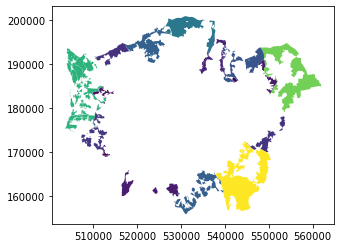

In [15]:
LAD_greenbelt.plot(column='Area_Ha')
LAD_greenbelt

In [16]:
# Write out to a new, smaller file
LAD_greenbelt.to_file('Data_Gen/Greenbelt_LAD.gpkg', driver="GPKG")